<a href="https://colab.research.google.com/github/SayanDas07/KWS-using-FewShotLearning/blob/main/TL(only_3keywords).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Fri Jun 13 05:40:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
!wget -O speech_commands_v0.02.tar.gz http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz

--2025-06-13 05:41:41--  http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.2.207, 74.125.137.207, 142.250.101.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.2.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2428923189 (2.3G) [application/gzip]
Saving to: ‘speech_commands_v0.02.tar.gz’

speech_commands_v0. 100%[===================>]   2.26G   250MB/s    in 17s     

2025-06-13 05:41:58 (139 MB/s) - ‘speech_commands_v0.02.tar.gz’ saved [2428923189/2428923189]



In [ ]:
!mkdir -p data_10_wav/data

In [ ]:
!tar -xzf speech_commands_v0.02.tar.gz -C data_10_wav/data

In [ ]:
DATASET_PATH = "data_10_wav/data/"
save_path = "/content/drive/MyDrive/NITDGP"

In [ ]:
SAMPLES_TO_CONSIDER = 16000
frame_length = int(SAMPLES_TO_CONSIDER * (32 / 1000))
hop_length = int(SAMPLES_TO_CONSIDER * (16 / 1000))


os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(save_path, exist_ok=True)

In [ ]:
print("frame_length:", frame_length)
print("hop_length:", hop_length)

frame_length: 512
hop_length: 256


In [ ]:
new_keywords = ['tree', 'marvin', 'one']
new_keyword_index = {k: i for i, k in enumerate(new_keywords)}
print("Keyword Index Mapping:", new_keyword_index)

Keyword Index Mapping: {'tree': 0, 'marvin': 1, 'one': 2}


In [ ]:
def hamming_window(length):
    return 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(length) / (length - 1))

In [ ]:
labels = []
log_mel_spectrograms = []

In [ ]:
labels

[]

In [ ]:
class_sample_counts = {kw: 0 for kw in new_keywords}

In [ ]:
for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
    label = os.path.basename(dirpath)
    if label in new_keywords:
        print(f"\nProcessing: '{label}'")
        count = 0

        for f in filenames:
            file_path = os.path.join(dirpath, f)
            try:
                signal, _ = librosa.load(file_path, sr=16000)
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
                continue

            if len(signal) >= SAMPLES_TO_CONSIDER:
                signal = signal[:SAMPLES_TO_CONSIDER]
            else:
                signal = np.pad(signal, (SAMPLES_TO_CONSIDER - len(signal), 0), mode='constant')

            signal = signal.astype(np.float32)
            windowed = signal * hamming_window(SAMPLES_TO_CONSIDER)

            mel_spec = librosa.feature.melspectrogram(
                y=windowed,
                sr=16000,
                n_mels=40,
                n_fft=frame_length,
                win_length=frame_length,
                hop_length=hop_length,
                center=False
            )

            log_mel = librosa.power_to_db(mel_spec, ref=np.max)
            log_mel_spectrograms.append(log_mel.T)
            labels.append(new_keyword_index[label])

            count += 1
            if count >= 500:
                break


Processing: 'one'

Processing: 'tree'

Processing: 'marvin'


In [ ]:
np.save(os.path.join(save_path, 'X_log_mel_spectrograms_TL3.npy'), np.array(log_mel_spectrograms))
np.save(os.path.join(save_path, 'y_log_mel_spectrograms_TL3.npy'), np.array(labels))
print("Feature extraction done and saved.")


Feature extraction done and saved.


In [ ]:
X = np.load(os.path.join(save_path, 'X_log_mel_spectrograms_TL3.npy'))
y = np.load(os.path.join(save_path, 'y_log_mel_spectrograms_TL3.npy'))

In [ ]:
print("X shape:", X.shape)  # (num_samples, time_steps, n_mels)
print("y shape:", y.shape)  # (num_samples,)


X shape: (1500, 61, 40)
y shape: (1500,)


In [ ]:
from collections import Counter
label_map = {'tree': 0, 'marvin': 1, 'one': 2}

inv_label_map = {v: k for k, v in label_map.items()}

label_counts = Counter(y)

for label_idx in sorted(label_counts):
    label_name = inv_label_map.get(label_idx, 'unknown')
    print(f"{label_name}: {label_counts[label_idx]} samples")

tree: 500 samples
marvin: 500 samples
one: 500 samples


In [ ]:
# Normalize
X = np.array([x / np.max(np.abs(x)) if np.max(np.abs(x)) > 0 else x for x in X])

# ✅ Remove extra dims and reshape correctly
X = np.squeeze(X)  # removes all dimensions of size 1, if any
if X.ndim == 3:
    X = X[..., np.newaxis]  # adds only (61, 40, 1) as required
y_cat = to_categorical(y, 13)

In [ ]:
print("X shape:", X.shape)  # (num_samples, time_steps, n_mels)
print("y shape:", y.shape)  # (num_samples,)


X shape: (1500, 61, 40, 1)
y shape: (1500,)


In [ ]:
base_model = load_model('/content/CNN_BASE_UK3000 (1).h5')

In [ ]:
for i, layer in enumerate(base_model.layers): print(i, layer.name)

0 input_layer
1 conv2d
2 relu1_1
3 conv2d_1
4 relu1_2
5 max_pooling2d
6 conv2d_3
7 re_lu
8 conv2d_4
9 conv2d_2
10 max_pooling2d_1
11 batch_normalization
12 add
13 res_relu_0
14 gap
15 fc1
16 dropout1
17 fc2
18 dropout2
19 fc3
20 dropout3
21 fc4
22 dropout4
23 output_layer


In [ ]:
set_trainable = False
for layer in base_model.layers:
    if layer.name == "dropout3":
        set_trainable = True
    layer.trainable = set_trainable
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
def build_transfer_model(base_model, w1=None, b1=None, w2=None, b2=None, dropout_rate=0.3):
    last_feature_output = base_model.get_layer("dropout4").output

    # 1st Dense layer
    x = layers.Dense(256, activation='relu', name="fc5")(last_feature_output)
    x = layers.Dropout(dropout_rate, name="dropout5")(x)  # 🔹 Dropout after fc1

    # 2nd Dense layer
    x = layers.Dense(128, activation='relu', name="fc6")(x)
    x = layers.Dropout(dropout_rate, name="dropout6")(x)  # 🔹 Dropout after fc2

    # 3rd Dense layer
    x = layers.Dense(64, activation='relu', name="fc7")(x)
    x = layers.Dropout(dropout_rate, name="dropout7")(x)  # 🔹 Dropout after fc2

    # Output layer
    x = layers.Dense(13, activation='softmax', name="output")(x)

    model = Model(inputs=base_model.input, outputs=x, name="TransferModel3")

    return model

In [ ]:
transfer_model = build_transfer_model(base_model)

In [ ]:
transfer_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
transfer_model.summary()

Model: "TransferModel3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 61, 40, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 61, 40,    │        832 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu1_1 (ReLU)      │ (None, 61, 40,    │          0 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 40,    │     25,632 │ relu1_1[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu1_2 (ReLU)      │ (None, 61, 40,    │          0 │ conv2d_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 31, 20,    │          0 │ relu1_2[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 31, 20,    │     51,264 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 31, 20,    │          0 │ conv2d_3[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 31, 20,    │    102,464 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 10,    │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 10,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 10,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 16, 10,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_relu_0 (ReLU)   │ (None, 16, 10,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap                 │ (None, 64)        │          0 │ res_relu_0[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc1 (Dense)         │ (None, 512)       │     33,280 │ gap[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout1 (Dropout)  │ (None, 512)       │          0 │ fc1[0][0]         │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 446,957 (1.71 MB)

 Trainable params: 58,637 (229.05 KB)

 Non-trainable params: 388,320 (1.48 MB)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, stratify=y, random_state=42)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',         # Monitor validation loss
    patience=3,                 # Stop after 3 epochs without improvement
    restore_best_weights=True  # Roll back to the best model
)

In [ ]:
history = transfer_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, callbacks=[early_stop])

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - accuracy: 0.2238 - loss: 2.3337 - val_accuracy: 0.6567 - val_loss: 1.0807
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4284 - loss: 1.3415 - val_accuracy: 0.5567 - val_loss: 0.9847
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4749 - loss: 1.1412 - val_accuracy: 0.4733 - val_loss: 0.9994
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4498 - loss: 1.2022 - val_accuracy: 0.6367 - val_loss: 0.9472
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5074 - loss: 1.0568 - val_accuracy: 0.6433 - val_loss: 0.8556
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5045 - loss: 1.0669 - val_accuracy: 0.6600 - val_loss: 0.9277
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5076 - loss: 1.0157 - val_accuracy: 0.6900 - val_loss: 0.8645
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5095 - loss: 1.0422 - val_accuracy: 0.5700 - val_lo

In [ ]:
loss, acc = transfer_model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {acc * 100:.2f}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6557 - loss: 0.8517

Test Accuracy: 64.33%


In [ ]:
y_pred = transfer_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


In [ ]:
print(classification_report(y_true_classes, y_pred_classes, target_names=new_keywords))

              precision    recall  f1-score   support

        tree       0.77      0.20      0.32       100
      marvin       0.53      0.83      0.64       100
         one       0.78      0.90      0.83       100

    accuracy                           0.64       300
   macro avg       0.69      0.64      0.60       300
weighted avg       0.69      0.64      0.60       300



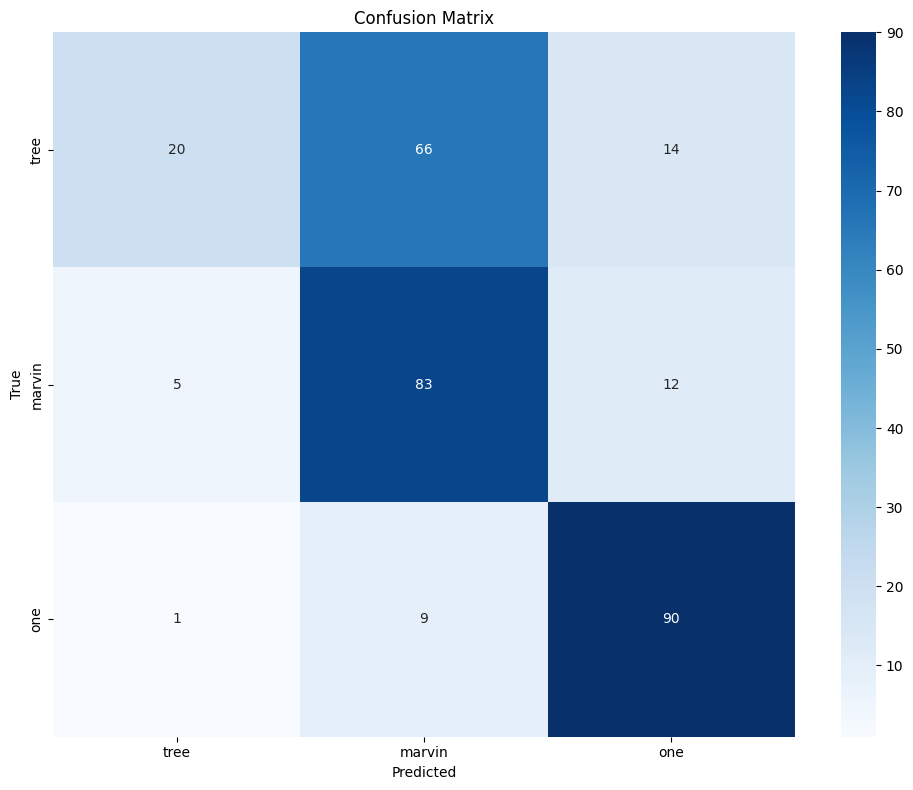

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=new_keywords, yticklabels=new_keywords)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()



In [ ]:
transfer_model.save(os.path.join(save_path, 'CNN_TLMODE.h5'))